## **Импорт и анализ данных.**

In [1]:
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Проверим данные на отсутствующие значения.

In [2]:
src_df = pd.read_csv('true_car_listings_prepeared.csv')

src_df.isna().sum()

Price           0
Year            0
Mileage    120943
City            0
State           0
Vin             0
Make            0
Model       77122
dtype: int64

Не очень хорошо, но не смертельно.

**Для начала нужно осмыслить данные, не затронутые порчей.**

Посмотрим на типы данных.

In [3]:
src_df.dtypes

Price        int64
Year         int64
Mileage    float64
City        object
State       object
Vin         object
Make        object
Model       object
dtype: object

In [4]:
src_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852122 entries, 0 to 852121
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Price    852122 non-null  int64  
 1   Year     852122 non-null  int64  
 2   Mileage  731179 non-null  float64
 3   City     852122 non-null  object 
 4   State    852122 non-null  object 
 5   Vin      852122 non-null  object 
 6   Make     852122 non-null  object 
 7   Model    775000 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 52.0+ MB


Памяти не много, так что оставлю как есть.

VIN точно никак ни на что не влияет, поскольку это изначально уникальный идентификатор. Удаляем.

In [5]:
print("Dataframe:\n\t-Columns:{}\n\t-Rows count:{}\n".format(src_df.columns, src_df.shape[0]))

Dataframe:
	-Columns:Index(['Price', 'Year', 'Mileage', 'City', 'State', 'Vin', 'Make', 'Model'], dtype='object')
	-Rows count:852122



In [6]:
src_df.drop(['Vin'], axis=1, inplace=True)
print("Dataframe:\n\t-Columns:{}\n\t-Rows count:{}\n".format(src_df.columns, src_df.shape[0]))

Dataframe:
	-Columns:Index(['Price', 'Year', 'Mileage', 'City', 'State', 'Make', 'Model'], dtype='object')
	-Rows count:852122



Посмотрим на диапазоны цены и пробега.

In [7]:
print("Range of prices is:\t{}".format(src_df.Price.max() - src_df.Price.min()))
print("Range of mileage is:\t{}".format(src_df.Mileage.max() - src_df.Mileage.min()))

Range of prices is:	499500
Range of mileage is:	2856191.0


Многовато. Натуральный логорифм нам в помощь.<br>
Но есть нюанс - нулевые значения. Посмотрим есть ли они и сколько.

In [8]:
src_df.isin([0]).sum()

Price      53308
Year           0
Mileage        0
City           0
State          0
Make           0
Model          0
dtype: int64

Нда. В этом датасете хоть что-то в порядке?<br>
Получается, автомобили с нулевой ценой это что? Заберите даром? Ну такое, в принципе, возможно. Но только для очень старых или битых автомобилей. 

In [9]:
print(src_df['Year'].max())

2018


In [10]:
wrong_price_mask = (src_df['Year'] > (2000)) & (src_df['Price'] == 0)
src_df.loc[wrong_price_mask]

,Price,Year,Mileage,City,State,Make,Model
4,0,2016,NaN,Lindon,UT,Acura,ILXAutomatic
49,0,2014,16848.0,Clearwater,FL,Acura,ILX5-Speed
74,0,2014,21064.0,Stanton,CA,Acura,TSX5-Speed
79,0,2015,18583.0,Montclair,CA,Acura,ILX5-Speed
91,0,2012,81301.0,Homestead,FL,Acura,NaN
...,...,...,...,...,...,...,...
852015,0,2016,43699.0,Odessa,TX,Volvo,XC90AWD
852044,0,2016,14942.0,Clive,IA,Volvo,XC90AWD
852060,0,2016,18435.0,Oak Park,IL,Volvo,XC90AWD
852095,0,2017,3335.0,Concord,NH,Volvo,V90


Поскольку у нас нет никаких данных о состоянии автомобиля, предположу, что это ошибка ввода. Именно эти значения мне и нужно будет предсказать в итоге.

In [11]:
print("Original:\n-----\n{}\n".format(src_df['Price'].sample(n=5, random_state=42)))

src_df['Price'] = src_df.apply(lambda x: np.log(x.Price) if x.Price != 0 else 0, axis=1)

print("Ln applyed:\n-----\n{}\n".format(src_df['Price'].sample(n=5, random_state=42)))

Original:
-----
729827    17300
825968    12615
353439    22995
477184    53692
282908    20900
Name: Price, dtype: int64

Ln applyed:
-----
729827     9.758462
825968     9.442642
353439    10.043032
477184    10.891019
282908     9.947504
Name: Price, dtype: float64



In [12]:
src_df.isin([0]).sum()

Price      53308
Year           0
Mileage        0
City           0
State          0
Make           0
Model          0
dtype: int64

Как видно, нулевые значения не стали np.inf.

In [13]:
print("Original:\n-----\n{}\n".format(src_df['Mileage'].sample(n=5, random_state=42)))
src_df['Mileage'] = src_df['Mileage'].apply(np.log)
print("Ln applyed:\n-----\n{}\n".format(src_df['Mileage'].sample(n=5, random_state=42)))

Original:
-----
729827    53490.0
825968    41451.0
353439    32655.0
477184        NaN
282908    34284.0
Name: Mileage, dtype: float64

Ln applyed:
-----
729827    10.887250
825968    10.632267
353439    10.393753
477184          NaN
282908    10.442434
Name: Mileage, dtype: float64



Год производства. Сам по себе этот параметр мало что значит. Попробую переделать его в возраст (Age). <br>
1 if Age <= 5<br>
2 if 5 < Age <= 10<br>
3 if 10 < Age <= 20<br>
4 if 20 < Age<br>

И тут произошло интересное. Я год из числового значения перевёл в категориальное.

**Категориальные данные.**

Тут всё не слишком сложно. Есть две основные методики оформить категориальные данные. Подстановка числового (выбранного по разным алгоритмам) значения или унитарный код (Hash, по сути, вариант унитарного кода). <br>
Просто взглянув на унитарный код становится понятно, что придется добавить много предикторов и всё станет не очень наглядно. Но есть один нюанс. Если просто подставить числа, то как понять, что модель автомобиля с числом 1 равнозначна модели с числом 2300? Да вобщем никак.<br>
Унитарный же код, если вспомнить уравнение линейной регрессии, позволяет моментально выкинуть (за счет нулевых значений предикторов) целый пласт значений из расчета. Тем самым, по идее, должна вырости точность модели. Посмотрим. 

Добавлю новые столбцы - Age_0_5, Age_6_10, Age_11_20, Age_20_. 

In [14]:
max_year = src_df['Year'].max()

age_0_5 = list()
age_6_10 = list()
age_11_20 = list()
age_20_ = list()

for year in src_df['Year']:
    age = max_year - year
    if age <= 5:
        age_0_5.append(1)
        age_6_10.append(0)
        age_11_20.append(0)
        age_20_.append(0)
    elif age > 5 and age <=10:
        age_0_5.append(0)
        age_6_10.append(1)
        age_11_20.append(0)
        age_20_.append(0)
    elif age > 10 and age <=20:
        age_0_5.append(0)
        age_6_10.append(0)
        age_11_20.append(1)
        age_20_.append(0)
    elif age > 20:
        age_0_5.append(0)
        age_6_10.append(0)
        age_11_20.append(0)
        age_20_.append(1)
    else:
        age_0_5.append(0)
        age_6_10.append(0)
        age_11_20.append(0)
        age_20_.append(0)

src_df['Age_0_5'] = age_0_5
src_df['Age_6_10'] = age_6_10
src_df['Age_11_20'] = age_11_20
src_df['Age_20_'] = age_20_

del age_0_5
del age_6_10
del age_11_20
del age_20_

In [15]:
print("-----\n{}\n".format(src_df.sample(n=5)))

-----
            Price  Year    Mileage         City State       Make       Model  \
514487  10.462846  2016        NaN   Schaumburg    IL       Jeep    Wrangler   
655545  10.092950  2016   8.543835        Logan    UT     Nissan         NaN   
115181   8.612322  2005  11.761542        Ceres    CA  Chevrolet  Equinox4dr   
798167   9.391661  2007  11.704215  Blairsville    GA     Toyota  Sequoia2WD   
355181   9.902987  2014  10.725204    Homestead    FL        GMC   AcadiaFWD   

        Age_0_5  Age_6_10  Age_11_20  Age_20_  
514487        1         0          0        0  
655545        1         0          0        0  
115181        0         0          1        0  
798167        0         0          1        0  
355181        1         0          0        0  



Попробую посмотреть корреляции.

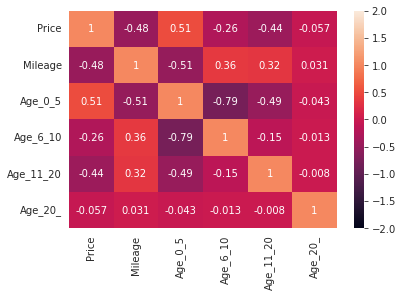

In [16]:
src_df.drop(['Year'], axis=1, inplace=True)

sns.set_style(style='white')
sns.set_palette(sns.color_palette("BrBG"))

numeric_df = src_df.select_dtypes(include=['float64', 'int64'])
numeric_df = numeric_df.loc[(src_df['Price'] != 0) & (src_df['Mileage'] != np.NaN) & (src_df['Model'] != np.NaN)]

sns.heatmap(numeric_df.corr(), annot=True, vmin=-2, vmax=2)

del numeric_df

Ну, ничего катастрофического я тут не вижу.

Попробую то же самое сделать с моделью и штатом. А вот город, пожалуй вобще исключу из исследования. Я не вижу, каким образом город может влиять на цену.

In [17]:
src_df.drop(['City'], axis=1, inplace=True)

In [18]:
states_one_hot = pd.get_dummies(src_df['State'])

src_df.drop(['State'], axis=1, inplace=True)

src_df = src_df.join(states_one_hot, how='right', rsuffix="state_")

del states_one_hot

In [19]:
models_one_hot = pd.get_dummies(src_df['Model'])

src_df = src_df.join(models_one_hot, how='right', rsuffix="model_")

del models_one_hot

In [20]:
makes_one_hot = pd.get_dummies(src_df['Make'])

src_df.drop(['Make'], axis=1, inplace=True)

src_df = src_df.join(makes_one_hot, how='right', rsuffix="make_")

del makes_one_hot

In [21]:
src_df.shape

(852122, 2818)

Количество столбцов настораживает.

In [22]:
src_df.isna().sum()

Price              0
Mileage       120943
Model          77122
Age_0_5            0
Age_6_10           0
               ...  
Tesla              0
Toyota             0
Volkswagen         0
Volvo              0
smart              0
Length: 2818, dtype: int64

In [23]:
src_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852122 entries, 0 to 852121
Columns: 2818 entries, Price to smart
dtypes: float64(2), int64(4), object(1), uint8(2811)
memory usage: 2.3+ GB


Немного (ну совсем чуть-чуть) выросло потребление памяти... В 40 раз...

In [24]:
#src_df.head

## **Импутация данных.**

И вот тольо теперь я могу попробовать импутировать недостающие данные...